In [3]:
from model import ImageCLIP, TextCLIP, CosineSimilarity
import clip
import torch
from data import CustomLabelDataset

device = torch.device('cuda:1')

def tokenize_class_label(texts):
    tokens = [clip.tokenize(f"A Photo of a {text}.") for text in texts]
    tokens = torch.stack(tokens).squeeze()
    return tokens

with open("data/class_labels.txt", "r") as fp:
    texts = [label.strip() for label in fp.readlines()]
    class_label = dict(enumerate(texts))
    
text_tokens = tokenize_class_label(texts).to(device)

/home/sangjun/.conda/envs/main/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


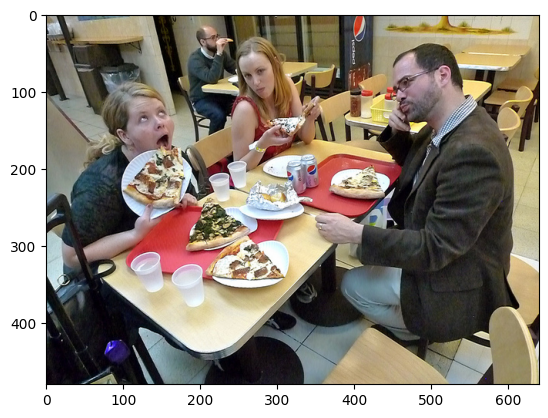

Answer: 67.0

Top predictions:

58: 30.88%
66: 29.03%
44: 10.35%
31: 8.85%
53: 7.11%


In [4]:
import matplotlib.pyplot as plt
import random

model, process = clip.load("ViT-B/32", device=device, jit=False)
text_model = TextCLIP(model).to(device)
image_model = ImageCLIP(model).to(device)
sim = CosineSimilarity()
dataset = CustomLabelDataset('../../data/coco/train2014', 'data/labels.json', process=process, original=True)

image_model = ImageCLIP(model)
text_model = TextCLIP(model)

sim = CosineSimilarity()

with torch.no_grad():
    text_embedding = text_model(text_tokens)

    idx = random.randint(0, len(dataset))
    x, img, cls = dataset[idx]
    plt.imshow(x.permute(1,2,0))
    plt.show()
    
    img, cls = img.unsqueeze(0).to(device), cls.to(device)
    image_embedding = image_model(img)
    
    image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
    text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_embedding @ text_embedding.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

    print(f"Answer: {cls + 1}")
    print("\nTop predictions:")
    
    for value, index in zip(values, indices):
        print(f"{index}: {100 * value.item():.2f}%")